Final Project: Neutron Diffusion

FTCS 2D Neutron Diffusion

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def normal(x,y,sigma):
    """Helper funciton that returns a 2D normal distribution evaluated at x,y"""
    return (np.exp(-(x*x+y*y)/(2*sigma*sigma)))/(sigma*np.sqrt(2*np.pi))

#physical constants
C = 1
D = 1
#lattice size constants
N=100
Nx=N
Ny=N

L=10

Tmax=15


alpha_pred=C-D*np.pi*np.pi*2/(L*L)# predicted lowest frequency amplification factor
#alpha > 0 means supercriticality


#boundary condition type
boundType=1 #0 for value, 1 for derivative
schemeType=0 # 0 for FTCS, 1 for LAX



if schemeType == 0:
    schemeName="FTCS"
elif schemeType ==1:
    schemeName="LAX"

if boundType ==0:
    boundName = "Boundaries: $n(x,y,t) = 0$"
    shortBoundName="Bounds n(x,y,t)=0"
    safeBoundName="Dirichlet"
elif boundType ==1:
    boundName= "Boundaries: $\\frac{\partial n(x,y,t)}{\partial x, y} = 0$"
    shortBoundName="Bounds d n(x,y,t) dx = 0$"
    safeBoundName="Neumann"

#Value based boundary conditions
if boundType == 0:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx inclusive
    hx=L/(Nx+1)
    hy=L/(Ny+1)
    x=-L/2 + x_ind*hx
    y=-L/2 + y_ind*hy
    boundval=0



# Derivative-based boundary conditions
if boundType == 1:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx+1 inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx+1 inclusive
    hx=L/Nx
    hy=L/Ny
    x= -L/2 +(x_ind-1/2)*hx
    y= -L/2 +(y_ind-1/2)*hy
    #the value for the derivative on the boundaries is set to zero


#numerical scheme constants
tau = 0.05
if schemeType == 0:
    #stabletau= hx*hy/(2*D)#THIS IS THE RESULT FOR 1D,THE 2D result is:
    stabletau=(hx**2*hy**2)/(hx**2+hy**2)*1/(2*D)
    #stabletau= hx*hy/(4*D) #2d stability criterion if hx=hy
    
elif schemeType ==1:
    stabletau=hx*hy/(4*D)
    #this is not the correct stability tau for LAX

if tau > stabletau:
    tau = stabletau*0.5
max_timestep=int(np.ceil(Tmax/tau))

# iterate 1 to Nx when loopin

grid=np.zeros((Nx+2,Ny+2))


Cgrid=np.ones((Nx+2,Ny+2))*C

#set up grid initial conditions
xp, yp = np.meshgrid(x, y)
grid=normal(xp,yp,1)

evolution=np.zeros((Nx+2,Ny+2,max_timestep))
evolution[:,:,0]=grid
if boundType ==0:
    grid[:,0]=boundval
    grid[:,-1]=boundval
    grid[0,:]=boundval
    grid[-1,:]=boundval
if boundType ==1:
    grid[:,0]=grid[:,1]
    grid[:,-1]=grid[:,-2]
    grid[0,:]=grid[1,:]
    grid[-1,:]=grid[-2,:]
    #the value for the derivative on the boundaries is set to zero
    evolution[:,:,0]=grid


for timestep in range(1,max_timestep):
 #update boundary values for record

    if schemeType == 0:
        #FTCS step
        grid[1:-1,1:-1]=grid[1:-1,1:-1]+D*tau*((grid[2:,1:-1]+grid[0:-2,1:-1]-2*grid[1:-1,1:-1])/(hx*hx)+(grid[1:-1,2:]+grid[1:-1,0:-2]-2*grid[1:-1,1:-1])/(hy*hy))+Cgrid[1:-1,1:-1]*tau*grid[1:-1,1:-1]
    elif schemeType == 1:
        laxavg=(grid[2:,1:-1]+grid[0:-2,1:-1]+grid[1:-1,2:]+grid[1:-1,0:-2])/4
        grid[1:-1,1:-1]=laxavg+D*tau*((grid[2:,1:-1]+grid[0:-2,1:-1]-2*laxavg)/(hx*hx)+(grid[1:-1,2:]+grid[1:-1,0:-2]-2*laxavg)/(hy*hy))+Cgrid[1:-1,1:-1]*tau*laxavg
        #lax step
    if boundType ==1:
        grid[:,0]=grid[:,1]
        grid[:,-1]=grid[:,-2]
        grid[0,:]=grid[1,:]
        grid[-1,:]=grid[-2,:]
        #the value for the derivative on the boundaries is set to zero
        #seems to be assigning by value rather than reference, which is good as by reference would break everything

    # by changing from a double loop over coordinates to an all-at-once matrix indexed option, a run went from 15.8 seconds to 0.266s
    # this was a transformation of i -> 1:-1, i+1 - > 2:, i-1 -> 0:-2
    #and the same for j
    evolution[:,:,timestep]=np.ndarray.copy(grid)

t= np.arange(max_timestep)*tau#create time indexing variable


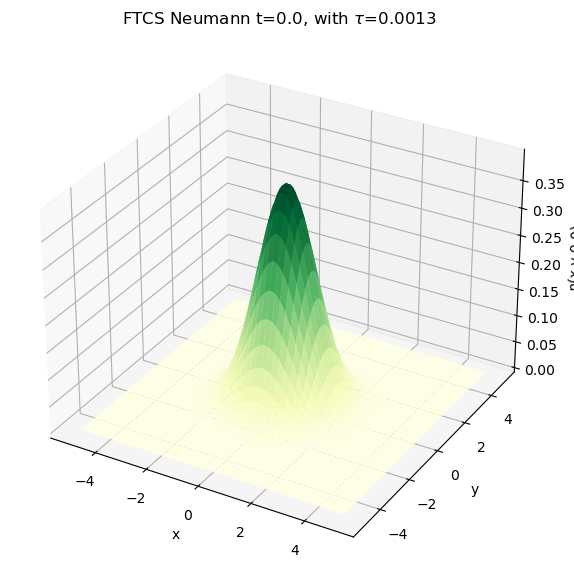

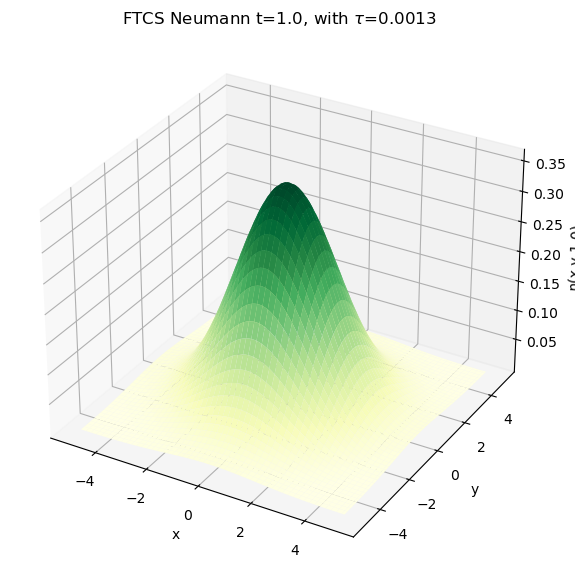

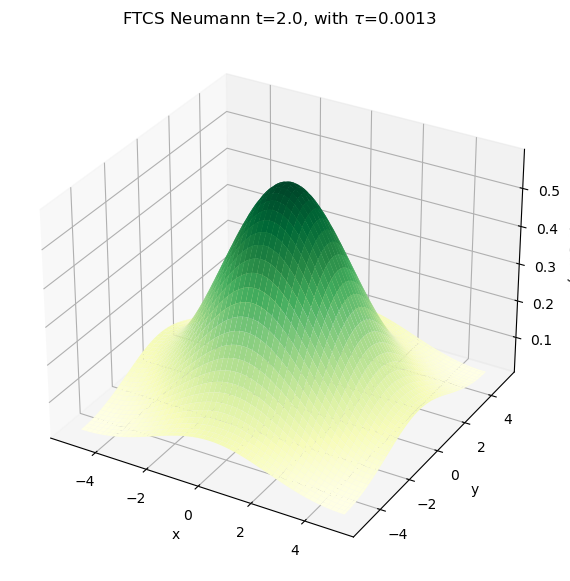

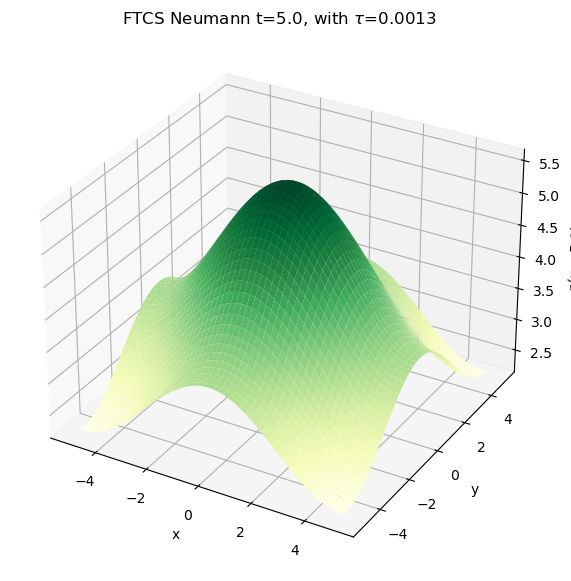

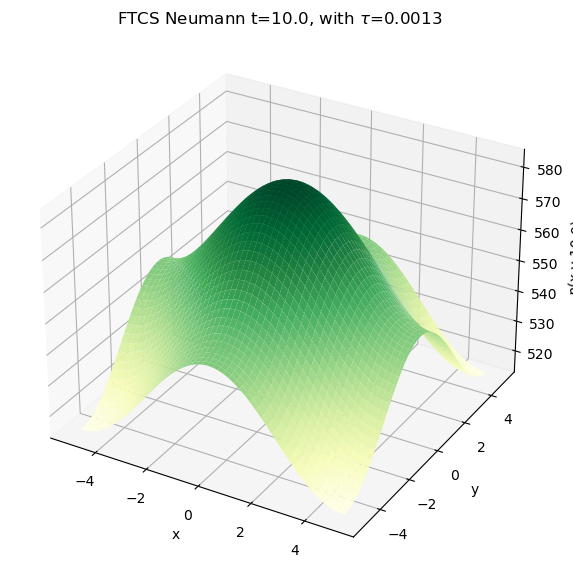

In [87]:
sampletimes = (0,1,2,5,10)

for sampleTime in sampletimes:

    t_slice_index=np.argmin(np.abs(t-sampleTime))

    timeslice=t[t_slice_index]
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    xp, yp = np.meshgrid(x, y)

    ax.plot_surface(xp, yp, evolution[:,:,t_slice_index], rstride=2, cstride=2, cmap='YlGn')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    plotitle=f'{schemeName} {safeBoundName} t={timeslice:.1f}, with $\\tau$={tau:.4f}'
    ignore=ax.set_title(plotitle)
    #ignore variable captures output that would otherwise get in the way
    ax.set_zlabel(f'n(x,y,{timeslice:.1f})')

    plt.savefig(f'plots\\{schemeName}\\{schemeName} tau={tau:.4f} t={timeslice:.1f} {shortBoundName}.png')


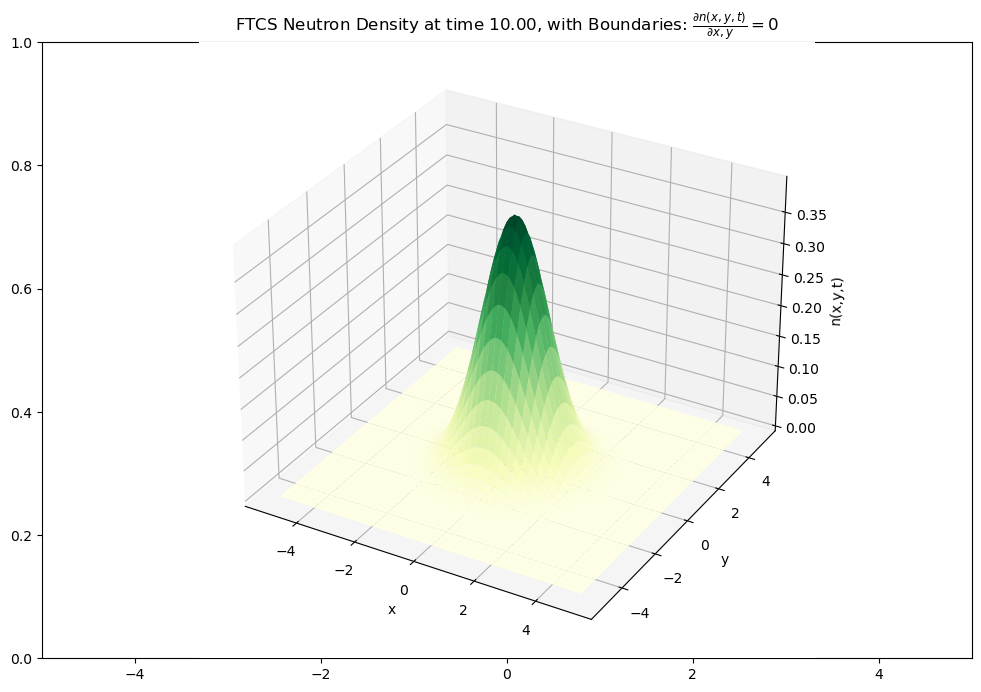

In [79]:
# ANIMATION CELL
import os
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(12,8))
ax.set(xlim=(-L/2,L/2))
ax = fig.add_subplot(projection='3d')

xp, yp = np.meshgrid(x, y)
curve=ax.plot_surface(xp, yp, evolution[:,:,0], rstride=2, cstride=2, cmap='YlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(f'n(x,y,t)')

plotitle=f'{schemeName} Neutron Density at time {timeslice:.2f}, with {boundName}'
plt.title(plotitle)
#ignore variable captures output that would otherwise get in the way

stop_frame=10000000
actual_stop_frame=min(stop_frame,max_timestep)

def animateDiffusion(i):
    """ Helper function that sets the curve at a given frame i so that it can be rendered to video"""
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(f'n(x,y,t)')
    curve=ax.plot_surface(xp, yp, evolution[:,:,i], rstride=2, cstride=2, cmap='YlGn')
    plt.title(f'{schemeName} Neutron Density at time {t[i]:.2f}, with {boundName}')
    if i % np.ceil(actual_stop_frame/100) == 0:
        print(f'{i/(actual_stop_frame)*100:.1f} % done')

    return curve


save_anim = False

anim_name=f'neutrons_C={C}_D={D}_t={tau:.4f}_T={max_timestep}_hx={hx:.4f}_L={L}_{schemeName}_bound={boundType}.mp4'
if os.path.isfile(anim_name):
    print('Animation already exists')

if save_anim and (N < 75) and (not os.path.isfile(anim_name)):
    anim=animation.FuncAnimation(fig,animateDiffusion,interval=1000*tau,frames=actual_stop_frame)
    anim.save(anim_name)

Compare to analytical solution of sines ina box for value=0 boundary conditions

Text(0.5, 1.0, 'Comparison of Solutions')

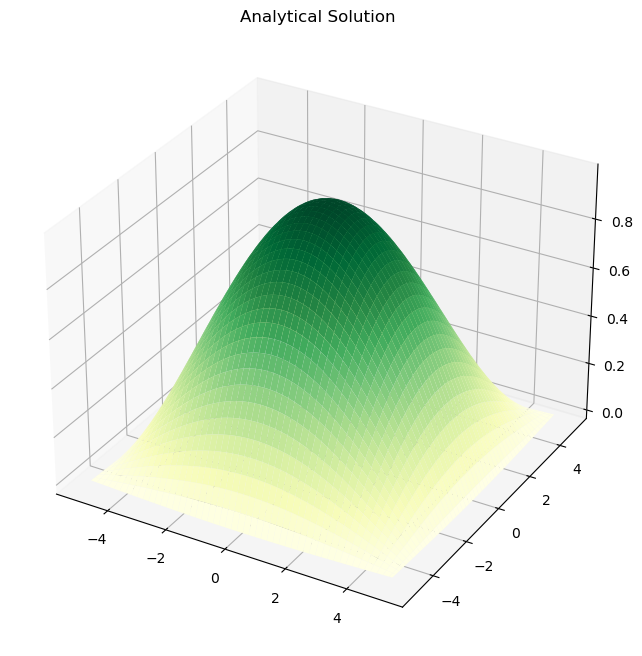

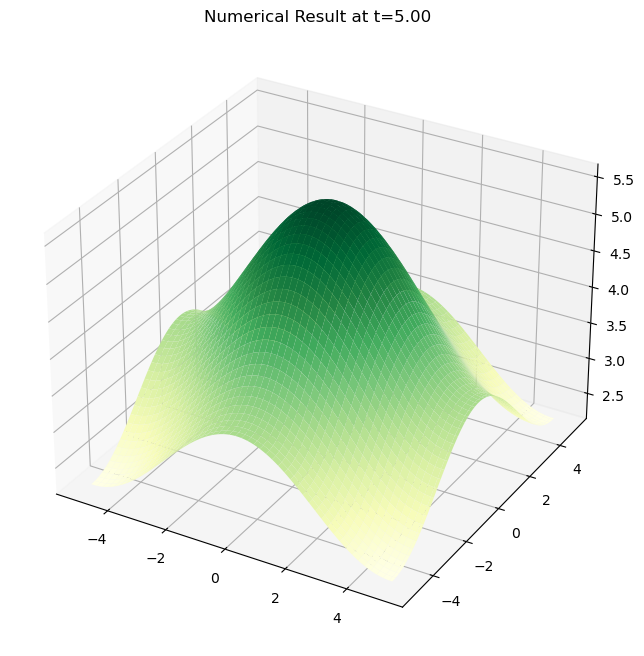

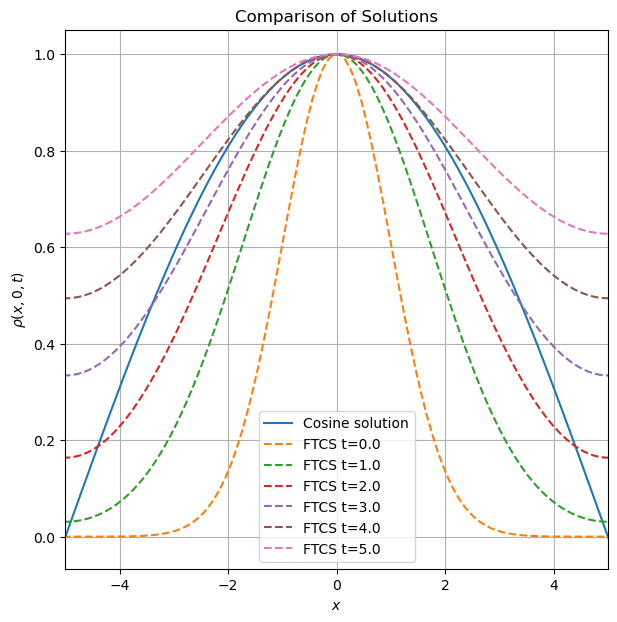

In [80]:
def analytic_soln(x,y,j_x=1,j_y=1):
    k=np.pi/L
    A=np.cos(k*x*(2*j_x-1))*np.cos(k*y*(2*j_y-1) )
    return A


sampleTime=5

t_slice_index=np.argmin(np.abs(t-sampleTime))

timeslice=t[t_slice_index]

xp, yp = np.meshgrid(x, y)
solut=analytic_soln(xp,yp)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

curve_soln=ax.plot_surface(xp, yp, solut, rstride=2, cstride=2, cmap='YlGn')
plt.title('Analytical Solution')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
curve_exper=ax.plot_surface(xp, yp, evolution[:,:,t_slice_index], rstride=2, cstride=2, cmap='YlGn')
plt.title(f'Numerical Result at t={timeslice:.2f}')



fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
curve_soln2=ax.plot(x,solut[:,(Ny+2)//2],label='Cosine solution')


timestep_of_graph=500
for graphtime in range(6):
    timestep_of_graph=int(graphtime//tau)
    norm_factor=np.max(evolution[:,(Ny+2)//2,timestep_of_graph])
    offset=0
    normed_offseted_soln=(evolution[:,(Ny+2)//2,timestep_of_graph]-offset)/norm_factor

    curve_exper2=ax.plot(x,normed_offseted_soln,label=f'{schemeName} t={t[timestep_of_graph]:.1f}',linestyle='--')

plt.xlabel('$x$')
plt.ylabel('$\\rho(x,0,t)$')
plt.grid()
plt.xlim(-L/2,L/2)
plt.legend()
plt.title(f'Comparison of Solutions')


Thank god this thing DOES look like what I expect for the analytical solution.

This thing devolves into the lowest frequency oscillation that fits in the box, which makes sense as in fourier space hte diffusion equation amplifies the lowest frequency components and squelches the high frequency components, as expected. The initial gaussian was gaussian in both frequency and real space in both dimensions, so along each dimension it had all the frequencies slowly culled by the diffusion behavior of the neutrons. Only the lowest frequency allowed remains, as the diffusion equation can't make the frequency go lower with the boundary condition of $\rho = 0$. The amplification behavior only adds an $e^{\alpha t}$ out front of the equation.

The same is true for the zero derivative version, but it has another few free parameters for the offset from zero and the amplitude (rather than the offset being zero, and hte amplitude accounted for entirely by the exponential growth), while also having twice the spatial frequency.

While zeroed boundary has $k = \frac{\pi}{L}$, zero derivative has spatial frequency $k = \frac{2\pi}{L}$

This isn't the whole story though, so it gets a bit too messy I think, to fully go into.

Okay, this didn't work so well. I may have another look at it later, but probably not. I could figure this out with time, but I don't have it on my side right now.
For a slice through the middle, it can work, but for the full 2D solution the corners get messed up and things don't work. I think the real solution is a bessel function.

Curve fit some of the n(t) to exponential curves, maybe show on semilogy chart

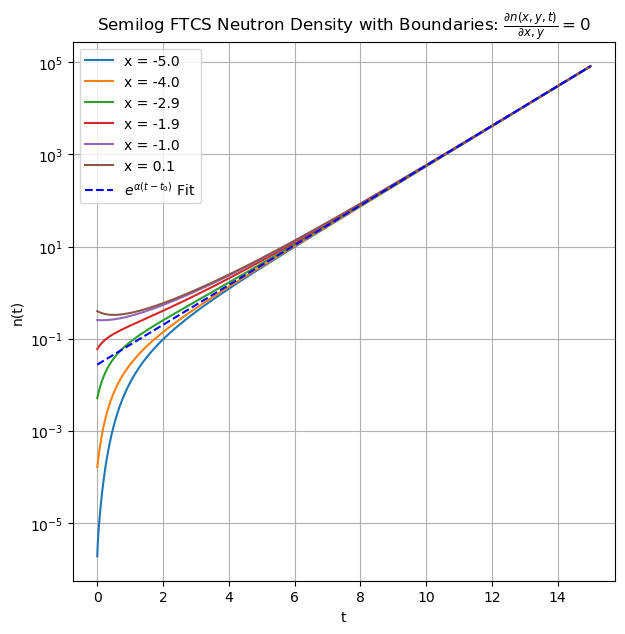

In [81]:
approx_center_index_x=int(np.ceil((Nx+2)/2))
approx_center_index_y=int(np.ceil((Ny+2)/2))

samplex=approx_center_index_x
sampley=approx_center_index_y

xval=x[samplex]
yval=y[sampley]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
num_cur=5
for xindex in range(samplex+1):
    if ((xindex-1) % int((samplex+1)/num_cur))  == 0:
        ax.semilogy(t,evolution[xindex,sampley,:],label=f'x = {x[xindex]:0.1f}')

ax.set_xlabel('t')
ax.set_ylabel(f'n(t)')
plotitle=f'Semilog {schemeName} Neutron Density with {boundName}'
plt.title(plotitle)
plt.grid()
try:
    plt.plot(t,result.eval(t=t),label='$e^{\\alpha (t-t_0)}$ Fit',linestyle='--',color='b')
except:
    pass
plt.legend()

Looks right. Points near edge of boundary start close to zero, then have density diffused into them, giving faster than exponential growth, while at these early times, points near the center lose a little bit of density to this diffusion. Then they all move quickly into an exponential growth mode once diffusion has moved the solution into a stable configuration with respect to boundary conditions. This solution is found by second 5 based on other graphs, but the most striking parts of the growth happen in the first two seconds, so that is where they are most visible on the graph. Not surprising, because the edge points start out at almost nothing, so even if they are half the value of what would be most stable,that barely shows on the semilog considering the several orders of magnitude they just grew by. Since the critical area is exceeded, we get exponential growth, with all points being attracted to different relative amplitudes based on their position in the plane.

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha    0.7443     -inf      inf 9.18e-05     True     None     None


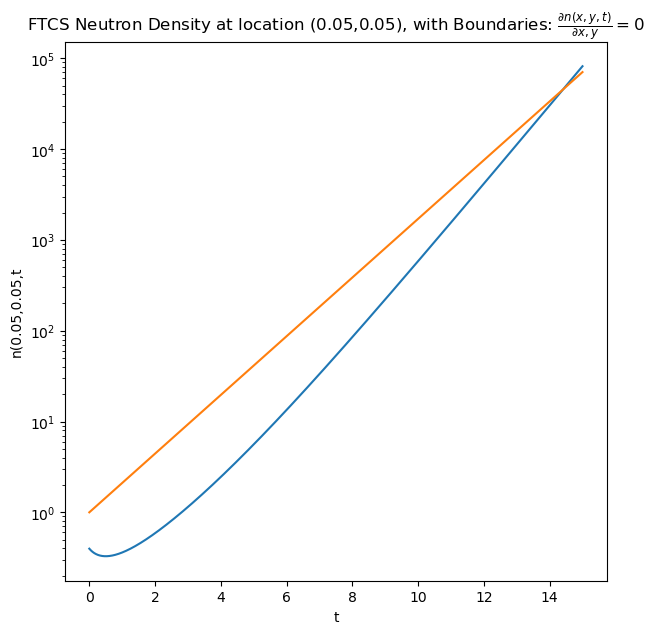

In [82]:
import lmfit
from lmfit import Model, Parameters
from lmfit.models import ExponentialModel

def ExpModel(t,alpha):
    """
    Helper function that evaluates exponetial increase fitting function I need
    given the parameters t and alpha
    e^(alpha t)
    params:
    alpha - the exponetial increase constant
    t- points to evaluate
    Returns:
    evaluated exponential function
    """
    return np.exp(alpha*t)

approx_center_index_x=int(np.ceil((Nx+2)/2))
approx_center_index_y=int(np.ceil((Ny+2)/2))

samplex=approx_center_index_x
sampley=approx_center_index_y

xval=x[samplex]
yval=y[sampley]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.semilogy(t,evolution[samplex,sampley,:])

ax.set_xlabel('t')
ax.set_ylabel(f'n({xval:.2f},{yval:.2f},t')
plotitle=f'{schemeName} Neutron Density at location ({xval:.2f},{yval:.2f}), with {boundName}'
ignore=ax.set_title(plotitle)

expmodel = Model(ExpModel,independent_vars=['t'])
result = expmodel.fit(evolution[samplex,sampley,:],t=t,alpha=1)
result.params.pretty_print()

plt.plot(t,result.eval(t=t),label='Fit')

Naive simple exponential does not fit well, as the exponential growth does not really start at time = 0. It starts a few seconds in, so another free parameter is necessary.

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha        0.994     -inf      inf 1.251e-05     True     None     None
t_offset     3.619     -inf      inf 0.0001371     True     None     None
[[Model]]
    Model(ExpModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 11999
    # variables        = 2
    chi-square         = 1279621.96
    reduced chi-square = 106.661829
    Akaike info crit   = 56033.2904
    Bayesian info crit = 56048.0755
    R-squared          = 0.99999945
[[Variables]]
    alpha:     0.99397461 +/- 1.2510e-05 (0.00%) (init = 1)
    t_offset:  3.61871307 +/- 1.3706e-04 (0.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, t_offset) = +0.9989


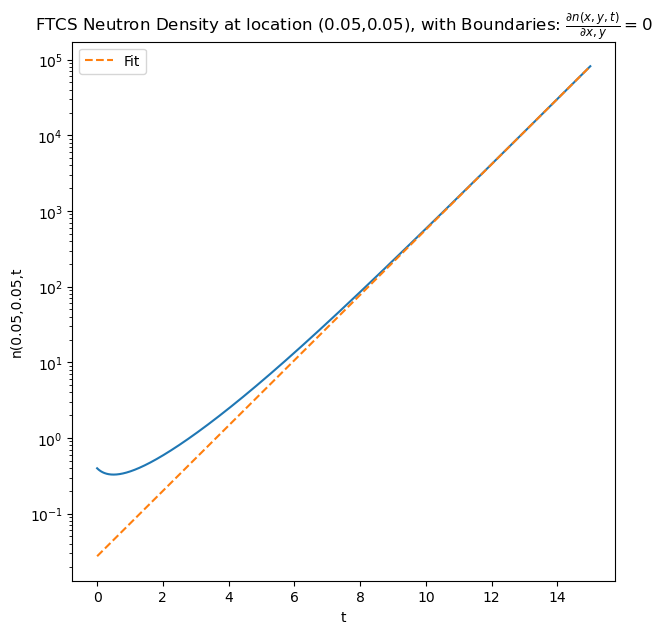

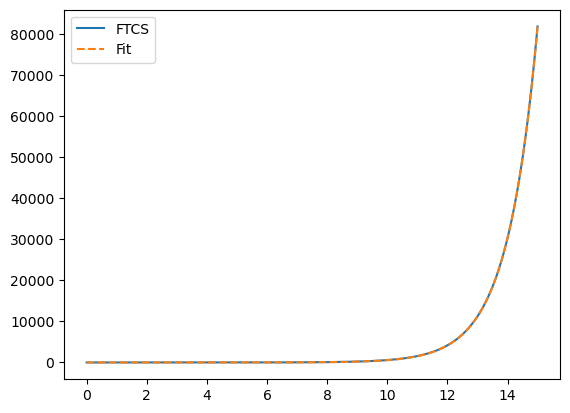

In [83]:
import lmfit
from lmfit import Model, Parameters
from lmfit.models import ExponentialModel

def ExpModel(t,alpha,t_offset):
    """
    Helper function that evaluates exponetial increase fitting function I need
    given the parameters t and alpha
    e^(alpha (t-t_offset)
    params:
    alpha - the exponetial increase constant
    t_offset- the offset for when the exponential growth really starts
    t- points to evaluate
    Returns:
    evaluated exponential function
    """
    return np.exp(alpha*(t-t_offset))

approx_center_index_x=int(np.ceil((Nx+2)/2))
approx_center_index_y=int(np.ceil((Ny+2)/2))

samplex=approx_center_index_x
sampley=approx_center_index_y

xval=x[samplex]
yval=y[sampley]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.semilogy(t,evolution[samplex,sampley,:],label='')

ax.set_xlabel('t')
ax.set_ylabel(f'n({xval:.2f},{yval:.2f},t')
plotitle=f'{schemeName} Neutron Density at location ({xval:.2f},{yval:.2f}), with {boundName}'
ignore=ax.set_title(plotitle)


start_time=0
expmodel = Model(ExpModel,independent_vars=['t'])
result = expmodel.fit(evolution[samplex,sampley,t>start_time],t=t[t>start_time],alpha=1,t_offset=0)

result.params.pretty_print()
print(result.fit_report())
plt.plot(t,result.eval(t=t),label='Fit',linestyle='--')
plt.legend()

plt.figure()
plt.plot(t,evolution[samplex,sampley,:],label=f'{schemeName}')
plt.plot(t,result.eval(t=t),label='Fit',linestyle='--')
plt.legend()

In [84]:
alpha_pred=C-D*np.pi*np.pi*2/(L*L)


AGREES with the fit very well!